# Case study - lokalizacja Wi-Fi

W folderze UJIndoorLoc znajdziecie pliki z danymi dotyczącymi lokalizacji w budynku na podstawie sygnałów z sieci WiFi. Problem jest o tyle ciekawy, że o ile lokalizacja na zewnątrz jest problemem prostym do rozwiązania (dobra jakość sygnału GPS), tak wewnątrz budynku jest już trudniej.

Jednym z proponowanych rozwiązań jest użycie mocy sygnału WiFi z punktów dostępu rozlokowanych wewnątrz budynku. Sygnał ten jednak jest na tyle niestabilny, że ciężko deterministycznie określić na jego podstawie dokładne położenie. Na szczęście z pomocą przychodzi machine learning!  

Waszym zadaniem jest skonstruowanie algorytmu, który będzie określał położenie użytkownika (tzn wysokość i szerokość geograficna oraz numer piętra) na podstawie wejściowych danych. Zależy nam zarówno na wysokiej skuteczności, jak i na szybkim czasie predykcji. 

Opis danych: https://archive.ics.uci.edu/ml/datasets/ujiindoorloc

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('./UJIndoorLoc/trainingData.csv')

In [3]:
test_data = pd.read_csv('./UJIndoorLoc/validationData.csv')

In [6]:
train_data.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [7]:
test_data['BUILDINGID'].value_counts()

0    536
1    307
2    268
Name: BUILDINGID, dtype: int64

In [9]:
train_data['BUILDINGID'].value_counts()

2    9492
0    5249
1    5196
Name: BUILDINGID, dtype: int64

## Uczymy na budynku nr 0.

In [10]:
X_train = train_data[train_data['BUILDINGID']==0]
X_test = test_data[test_data['BUILDINGID']==0]

# Mamy missing data

WAP001-WAP520: Intensity value for Wireless Access Point (WAP). WAP will be the acronym used for rest of this notebook. Negative integer values from -104 to 0 and +100. Censored data: Positive value 100 used if WAP was not detected.

In [11]:
X_train = (X_train
             .replace(to_replace=100,value=np.nan))

# Perform the same transform on Test data
X_test = (X_test
             .replace(to_replace=100,value=np.nan))

In [17]:
X_train.head(10)

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710
7119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7637.2570,4.864950e+06,0,0,102,2,11,13,1369908951
7120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7628.1345,4.864977e+06,0,0,110,2,11,13,1369909107
7121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7622.0546,4.864976e+06,0,0,111,2,11,13,1369909166
7122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7636.2057,4.864967e+06,0,0,107,2,11,13,1369909011
7123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7633.7295,4.864965e+06,0,0,106,2,11,13,1369909056
7124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7605.4193,4.864979e+06,0,0,115,2,11,13,1369909334
7125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7607.2476,4.864979e+06,0,0,114,2,11,13,1369909296
7126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7616.5560,4.864976e+06,0,0,113,2,11,13,1369909254
7127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-7618.5869,4.864975e+06,0,0,112,2,11,13,1369909217


# Co mamy przewidzieć


In [37]:
print(X_train['FLOOR'].value_counts())

2    1443
3    1391
1    1356
0    1059
Name: FLOOR, dtype: int64


In [39]:
y_lon_train = X_train['LONGITUDE'].values
y_lat_train = X_train['LATITUDE'].values
y_floor_train = X_train['FLOOR'].values

y_lon_test = X_test['LONGITUDE'].values
y_lat_test = X_test['LATITUDE'].values
y_floor_test = X_test['FLOOR'].values

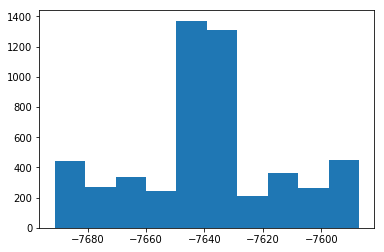

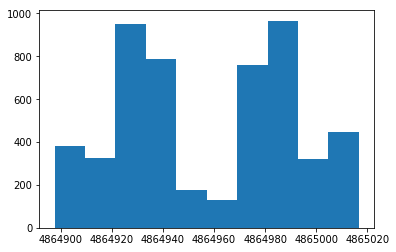

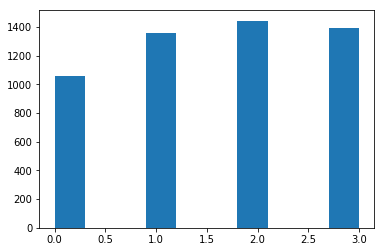

In [51]:
plt.hist(y_lon_train)
plt.show()

plt.hist(y_lat_train)
plt.show()

plt.hist(y_floor_train)
plt.show()

In [42]:
X_train.shape

(5249, 529)

In [45]:
cols_to_train = [i for i in train_data.columns if 'WAP' in i]
print(cols_to_train[:5], cols_to_train[-5:])

train_data.columns.str.contains('WAP')

train_data.filter(regex='WAP.*')

X_train = X_train[cols_to_train]

['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005'] ['WAP516', 'WAP517', 'WAP518', 'WAP519', 'WAP520']


In [46]:
X_train.shape

(5249, 520)

# Zad. 

* rozwiąż problem missing data 
* wykonaj standaryzacja danych
* selekcja cech 
  ```python
  from sklearn.feature_selection import VarianceThreshold
  ```
* selekcja cech wybierz tylko najważniejsze spółrzedne max 10
* zbudować model 
  * - na piętro - klasyfikacja, 
  * - długość i szerokość - regresja
* przetestować na zbiorze testowym 

In [21]:
# y_lon = X_train[['LONGITUDE']][:, 0]
# y_lat = X_train[['LATITUDE']][:, 0]
# y_floor = X_train['FLOOR']
# print(X_train['FLOOR'].value_counts())

In [47]:
# X_train = data[data['BUILDINGID'] == 0]

# y_lon = longitude_scaler.fit_transform(X_train[['LONGITUDE']])[:, 0]
# y_lat = latitude_scaler.fit_transform(X_train[['LATITUDE']])[:, 0]
# y_floor = X_train['FLOOR']
# print(X_train['FLOOR'].value_counts())

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# # pamiętamy, że obserwacje testowe musimy skalować tymi samymi transformacjami!
# latitude_scaler = MinMaxScaler()
# longitude_scaler = MinMaxScaler()

In [ ]:
# data[['LATITUDE']].shape

In [ ]:
# y_lon = longitude_scaler.fit_transform(data[['LONGITUDE']])[:, 0]

In [ ]:
#1. wyodrębnić kolumny na których będziemy uczyć model
#2.  obsłużenie '100' + standaryzacja danych
#3. selekcja cech
#4. zbudować model - na piętro - klasyfikacja, długość i szerokość - regresja
#5. przetestować na zbiorze testowym 

In [ ]:
print(X_train.shape, y_floor.shape, y_lat.shape, y_lon.shape)

In [ ]:
#1

cols_to_train = [i for i in data.columns if 'WAP' in i]
print(cols_to_train[:5], cols_to_train[-5:])

data.columns.str.contains('WAP')

data.filter(regex='WAP.*')

X_train = X_train[cols_to_train]

In [ ]:
X_train.shape

WAP001-WAP520: Intensity value for Wireless Access Point (WAP). WAP will be the acronym used for rest of this notebook. Negative integer values from -104 to 0 and +100. Censored data: Positive value 100 used if WAP was not detected.

In [ ]:
#2

X_train[X_train == 100] = -110
X_train.head()
X_train.describe()

In [ ]:
# ??MinMaxScaler

In [ ]:
# standaryzacja + selekcja + model
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

In [ ]:
KNeighborsClassifier??

In [ ]:
preprocessing_pipeline_classification = Pipeline([
    ('data scaling', MinMaxScaler()),
    ('remove zero variance', VarianceThreshold()),
    ('feature selection', RFE(RandomForestClassifier(), step=10)),
    ('model', KNeighborsClassifier())
])

In [ ]:
param_grid_classification = {
    'feature selection__n_features_to_select': [500, 460, 400, 340, 240, 120],
    'model__n_neighbors': [3, 5, 8]
}

In [ ]:
classification_grid_search = GridSearchCV(
    estimator=preprocessing_pipeline_classification,
    param_grid=param_grid_classification,
    cv=KFold(5, shuffle=True),
    n_jobs=-1
)

In [ ]:
GridSearchCV

In [ ]:
classification_grid_search.fit(X_train, y_floor)

In [ ]:
classification_grid_search.best_params_

In [ ]:
classification_grid_search.grid_scores_

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
preprocessing_pipeline_regression = Pipeline([
    ('data scaling', MinMaxScaler()),
    ('remove zero variance', VarianceThreshold()),
    ('feature selection', RFE(RandomForestRegressor(), step=20)),
    ('model', KNeighborsRegressor())
])

In [ ]:
param_grid_regression = {
    'feature selection__n_features_to_select': [500, 400, 300, 240, 120],
    'model__n_neighbors': [3, 5, 8]
}

In [ ]:
regression_grid_search = GridSearchCV(
    estimator=preprocessing_pipeline_regression,
    param_grid=param_grid_regression,
    cv=KFold(5, shuffle=True),
    n_jobs=-1
)

In [ ]:
regression_grid_search.fit(X_train, y_lat)

In [ ]:
regression_grid_search.best_params_

In [ ]:
latitude_estimator = regression_grid_search.best_estimator_
floor_estimator = classification_grid_search.best_estimator_

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

In [ ]:
# cross validation on training set
latitude_scores = cross_val_score(latitude_estimator, X=X_train, y=y_lat, cv=4, scoring=make_scorer(mean_absolute_error))

floor_scores = cross_val_score(floor_estimator, X=X_train, y=y_floor, cv=4)

In [ ]:
print(latitude_scores, latitude_scores.mean())

In [ ]:
floor_scores.mean()

In [ ]:
# final train
latitude_estimator.fit(X_train, y_lat)
floor_estimator.fit(X_train, y_floor)

In [ ]:
#6 test on test set

In [ ]:
from sklearn.base import TransformerMixin

class Replace100Transformer(TransformerMixin):
    def __init__(self, replacement=-100):
        self.replacement=replacement
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X[X == 100] = self.replacement
        return X
        

In [ ]:
X_test = test_data[test_data['BUILDINGID'] == 0]
#X_test[X_test == 100] = -110
y_lon_test = longitude_scaler.transform(X_test[['LONGITUDE']])[:, 0]
y_lat_test = latitude_scaler.transform(X_test[['LATITUDE']])[:, 0]
y_floor_test = X_test['FLOOR']

In [ ]:
lat_predictions = latitude_estimator.predict(X_test)

In [ ]:
mean_absolute_error(y_pred=lat_predictions, y_true=y_lat_test)

In [ ]:
X_test.shape

In [ ]:
# naprawić 100 na treningu
# sprawdzić wydajność modelu na piętrze